In [1]:
# please make sure your drive_path is set, so that the notebook can find the data files on the hard drive

# OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/cell_types_cache/'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# AWS
drive_path = '/data/dynamic-brain-workshop/cell_types_cache/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GLM_helpers import *
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input

from scipy.optimize import minimize

from allensdk.core.cell_types_cache import CellTypesCache

Using TensorFlow backend.


In [3]:
ctc = CellTypesCache(manifest_file=os.path.join(drive_path,'manifest.json'))

In [4]:
# pd.DataFrame(ctc.get_cells()).head()
cells = pd.DataFrame(ctc.get_cells(reporter_status='positive'))
print len(cells)
# cells.head()
# print cells.groupby(by='transgenic_line').size()
region = 'VISp'
inh_lines = ['inh']
exc_lines = ['exc']
exc_st = ['Rorb','Scnn','Nr5','Rbp','Emx','Cux','Tlx3','Sim1','Ntsr']
inh_st = ['Gad','Htr','Pvalb','Vip','Sst']
layer = '4'
for line in cells.transgenic_line.unique():
    for st in exc_st:
        if line.startswith(st):
            exc_lines.append(line)
    for st in inh_st:
        if line.startswith(st):
            inh_lines.append(line)


has_line = False
# lines = ['Rorb-IRES2-Cre']
for line in inh_lines:
    has_line = has_line | (cells.transgenic_line==line)
inh_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name==layer)]
print len(inh_cells)

has_line = False
for line in exc_lines:
    has_line = has_line | (cells.transgenic_line==line)
exc_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name==layer)]
print len(exc_cells)

1813
129
259


In [5]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, Lambda
from keras.regularizers import Regularizer
from keras.callbacks import ModelCheckpoint
from keras.regularizers import Regularizer



class GroupAndPriors(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, size_stim, size_filt, prior = None, i=None, lprior = 0, lgroup = 0.):
        self.lgroup = K.cast_to_floatx(lgroup)
        if prior is not None:
            self.lprior = K.cast_to_floatx(lprior)
            self.i = i
            self.W_means = prior['W_means']
            self.W_vars = prior['W_vars']
            self.W_weights = prior['W_weights']
            self.lsmooth = K.cast_to_floatx(1.0*lprior) #fudge factor here to account for relationship between priors
        else:
            self.lprior = 0
            self.lsmooth = 0
            
        self.size_filt = size_filt
        self.size_stim = size_stim

    def __call__(self, x): 
        xr = K.reshape(x[self.size_stim:], (-1, self.size_filt))
        pen = 0.
        if self.lgroup > 0:
            pen += self.lgroup * np.sqrt(K.int_shape(xr)[1])*K.sum(K.sqrt(K.sum(K.square(xr),axis=1)))
        if self.lprior > 0:
            pen += self.lprior * K.sum(-K.log(K.epsilon()+K.sum(self.W_weights*K.exp(-0.5*K.square(K.repeat_elements(K.expand_dims(xr[self.i,:],axis=0),self.W_means.shape[0],0)-self.W_means)/self.W_vars),axis=0)))
        if self.lsmooth > 0:
            pen += self.lsmooth * K.sum(K.square(xr[self.i,:-1]-xr[self.i,1:]))
        return pen
    
class BiasPrior(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, prior = None, lprior = 0):
        if prior is not None:
            self.lprior = K.cast_to_floatx(lprior)
            self.b_mean = prior['b_mean']
            self.b_std = prior['b_std']            
        else:
            self.lprior = 0


    def __call__(self, x): 
        return self.lprior * K.square((x-self.b_mean)/self.b_std)

def construct_GLM_mat(flat_stimulus, binned_spikes, d, spk_filts=None):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     print("N,T", (N,T))
#     print("M,T", (M,T))
    if spk_filts is not None:
        X_dsn = np.empty((T-d,M*d+N*spk_filts.shape[1]))
    else:
        X_dsn = np.empty((T-d,M*d+N*d))
    for t in range(T-d):
        X_dsn[t,:M*d] = np.fliplr(flat_stimulus[:,t:t+d]).reshape((1,-1))  #stimulus inputs
    if spk_filts is not None:
        for i in range(N):
            for j in range(spk_filts.shape[1]):
                X_dsn[:,M*d+i*spk_filts.shape[1]+j] = np.convolve(binned_spikes[i,:],spk_filts[:,j],mode='valid')[:T-d]
    else:
        for t in range(T-d):
            X_dsn[t,M*d:] = np.fliplr(binned_spikes[:,t:t+d]).reshape((1,-1)) #spike inputs
    return X_dsn

# tells keras not to use the GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.callbacks import LearningRateScheduler
from scipy.special import gamma

def exp_decay(t):
    initial_lrate = 4e-3
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate

def filt_func(t,a,b):
    return t**(a-1)*np.exp(-b*t)*b**a/gamma(a)

def make_filts(num_filts=15,f_mean_range=(1e-3,0.04),f_var_range=(1e-6,6e-5),dt=1e-3,d=40):
    f_means = np.logspace(np.log10(f_mean_range[0]),np.log10(f_mean_range[1]),num=num_filts)
    f_vars = np.logspace(np.log10(f_var_range[0]),np.log10(f_var_range[1]),num=num_filts)
#    print f_means, f_vars
    f_bs = f_means/f_vars
    f_as = f_means*f_bs
    t = np.arange(1,d+1)*dt
    filts = np.empty((d,num_filts))
    for i in range(num_filts):
        filts[:,i] = filt_func(t,f_as[i],f_bs[i])
        filts[:,i] /= sum(filts[:,i])
#    print np.sum(filts*np.tile(t,(num_filts,1)).T,axis=0)
    return filts
    
# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')
from keras.callbacks import EarlyStopping

def GLM_network_fit(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None,dt=1e-3,filts=None):
    Xdsn = construct_GLM_mat(stimulus,spikes, d, spk_filts=filts)
    
    N = spikes.shape[0]
#     print("N", N)
    M = stimulus.shape[0]
#     print("M", M)
    F = np.empty((N,M,d)) # stimulus filters
    if filts is not None:
        W = np.empty((N,N,filts.shape[1]))  # spike train filters
    else:
        W = np.empty((N,N,d))  # spike train filters
    b = np.empty((N,)) # biases
    losses = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    for i in range(N):
        y = spikes[i,d:]
        # construct GLM model and return fit
        model = Sequential()
        if priors is not None:
            model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True,
                            kernel_regularizer=GroupAndPriors(M*d,filts.shape[1],lgroup=0,lprior = 1e-5,prior=priors[cell_types[i]],i=i),
                            kernel_initializer=keras.initializers.RandomUniform(minval=np.min(priors[cell_types[i]]['W_means'][0,:]-2*np.sqrt(priors[cell_types[i]]['W_vars'][0,:])),maxval=np.max(priors[cell_types[i]]['W_means'][-1,:]+2*np.sqrt(priors[cell_types[i]]['W_vars'][-1,:]))),
                            bias_regularizer=BiasPrior(prior=priors[cell_types[i]],lprior=1e-5),
                            bias_initializer=keras.initializers.RandomNormal(mean=priors[cell_types[i]]['b_mean'],stddev=priors[cell_types[i]]['b_std'])
                           ))
        else:
            model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=4e-3))
#        checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=False)
        model.fit(x=Xdsn,y=y,batch_size=5000,epochs=5,verbose=2,callbacks=[LearningRateScheduler(exp_decay)]) #, EarlyStopping(monitor='loss',min_delta=0.00005,patience=3)
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d].reshape((M,d))
        if filts is not None == 0:
            W[i,:,:] = p[M*d:].reshape((N,d))
        else:
            W[i,:,:] = p[M*d:].reshape((N,filts.shape[1]))
        b[i] = model.get_weights()[1]
#         losses[i] = model.evaluate(x=Xdsn,y=y,verbose=0)
        models.append(model)
    return (F,W,b,losses,models)

In [6]:
def get_sweeps_with_stim(ephys_data,stim_type):
    sweeps = []
    for i in ephys_data.get_experiment_sweep_numbers():
        if str.startswith(str(ephys_data.get_sweep_metadata(i)['aibs_stimulus_name']),stim_type):
            sweep = ephys_data.get_sweep(i)
            sweep['spike_times'] = ephys_data.get_spike_times(i)
            sweeps.append(sweep)
    return sweeps

def bin_spikes_and_stim(sweeps,bin_len,zpad=0):
    spikes_list = []
    stim_list = []
    for sweep in sweeps:
        T = int(np.floor(sweep['index_range'][1]*1.0/(sweep['sampling_rate']*bin_len)))
        binned_spikes = np.zeros((1,T))
        binned_stim = np.empty((1,T))
        for spike_time in sweep['spike_times']:
            t = int(np.floor(spike_time/bin_len))
            binned_spikes[0,t]+=1
        for i in range(T):
            binned_stim[0,i] = np.mean(sweep['stimulus'][int(np.round(i*bin_len*sweep['sampling_rate'])):int(np.round((i+1)*bin_len*sweep['sampling_rate']))])
        spikes_list.append(binned_spikes)
        stim_list.append(binned_stim)
        if zpad>0:
            spikes_list.append(np.zeros((1,int(np.floor(zpad/bin_len)))))
            stim_list.append(np.zeros((1,int(np.floor(zpad/bin_len)))))
    binned_spikes = np.hstack(spikes_list)
    binned_stim = np.hstack(stim_list)
    return (binned_spikes, binned_stim)
        
    
    """
    - use stim kernel convolved with alpha function as prior for synapse
    """

36

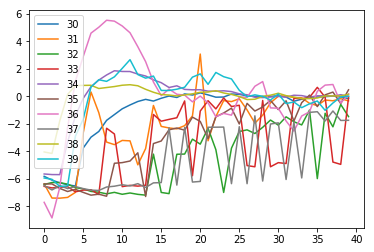

In [10]:
def construct_Xdsn(stim,spks,d):
    X_dsn = np.ones((stim.size-d,2*d+1))
    for i in range(stim.size-d):
        X_dsn[i,:d] = np.flip(stim[i:i+d],0)
        X_dsn[i,d:-1] = np.flip(spks[i:i+d],0)
    return X_dsn

def fit_GLM(stim,spks,d):
    model =  sm.GLM(spks[d:],construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    model_results = model.fit()
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    stim_filt = p[:d]
    spk_filt = p[d:-1]
    return stim_filt, spk_filt, b, se

D = np.load('inh_VISp_5.npz')
plt.plot(D['W_clump'][30:40,:].T)
plt.legend(np.arange(30,40))
36

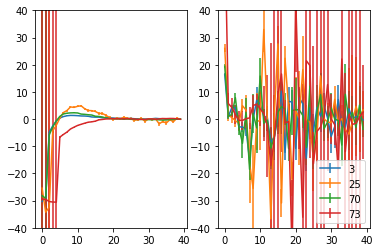

In [28]:
bin_len = 0.001
d=40

for line in inh_lines:
    has_line = has_line | (cells.transgenic_line==line)
cell_ids = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev=='VISp') & (cells.structure_layer_name=='5')]['id'].values
#43,44, 55,56,57, 65,67 missing
nums = [3,25, 70, 73]#np.arange(40) #45 might burst, 70 is burst, 73 is clean
used_nums = []
fig, (ax1, ax2) = plt.subplots(1,2)
for num in nums:
    sweeps = get_sweeps_with_stim(ctc.get_ephys_data(cell_ids[num]),'Noise')
    if len(sweeps)>0:
        used_nums.append(num)
        (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
        F, W, b, se = fit_GLM(binned_stim.squeeze()*1e9,binned_spikes.squeeze(),d)
        ax1.errorbar(np.arange(d),W.squeeze(),yerr=se[d:-1])
        ax1.set_ylim([-40,40])
        ax2.errorbar(np.arange(d),F.squeeze(),yerr=se[0:d])
        ax2.set_ylim([-40,40])
    else:
        print num
plt.legend(used_nums)





3


(array([ 15., 192., 341., 237., 134., 153.]),
 array([3., 4., 5., 6., 7., 8., 9.]),
 <a list of 6 Patch objects>)

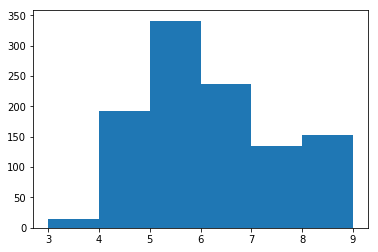

In [91]:
_,spk_times = np.nonzero(binned_spikes)
ISIs = np.diff(spk_times)
print np.min(ISIs)
plt.hist(ISIs[ISIs<10],bins=6)

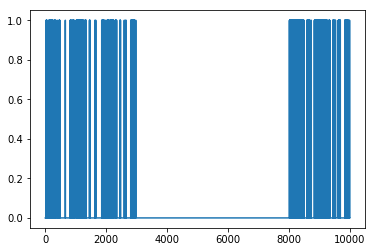

In [77]:
# export current and spike data to .txt files

# cell_id = cells['id'].values[0]
# sweeps = get_sweeps_with_stim(ctc.get_ephys_data(cell_id),'Noise')
# binned_spikes, binned_stim = bin_spikes_and_stim(sweeps,0.001)

plt.plot(binned_spikes.T[10000:20000])
#cell1 is exc_visp_5 cell#73: adapting
#cell2 is exc_visp_5 cell#70: bursting

# np.savetxt('binned_spikes_cell_1.txt',binned_spikes,delimiter=',',fmt='%.1d')
# np.savetxt('binned_stim_cell_1.txt',binned_stim*1e9,delimiter=',',fmt='%.6e')

In [ ]:
import os.path
bin_len = 0.001
d=40
t = np.arange(d)*bin_len

region = 'VISp'
layers = np.unique(cells.structure_layer_name.values)

for lines in [inh_lines, exc_lines]:
    for layer in layers:
        has_line = False
        for line in lines:
            has_line = has_line | (cells.transgenic_line==line)
        if os.path.isfile(str(lines[0]) + '_' + region + '_' + layer[0]+'_ftemps.npz'):
            continue
        print layer
        cell_ids = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name==layer)]['id'].values
        if len(cell_ids)>0:
            F_clump = []
            W_clump = []
            b_clump = []
            loss_clump = []
            for i, cell_id in enumerate(cell_ids):
                if np.mod(i,20)==0:
                    print i, '/', len(cell_ids)
                sweeps = get_sweeps_with_stim(ctc.get_ephys_data(cell_id),'Noise')
                if len(sweeps)>0:
                    (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
                    (F,W,b,loss,_) = GLM_network_fit(binned_stim*1e9,binned_spikes, d, bin_len, filts=make_filts())
                    F_clump.append(np.squeeze(F))
                    W_clump.append(np.squeeze(W))
                    b_clump.append(np.squeeze(b))
                    loss_clump.append(np.squeeze(loss))
#                     if len(b_clump) == 70:
#                         break

            F_clump = np.vstack(F_clump)
            W_clump = np.vstack(W_clump)
            b_clump = np.vstack(b_clump)
            loss_clump = np.vstack(loss_clump)
            
            if layer == '2/3':
                lname = '2'
            else:
                lname = layer
            np.savez(str(lines[0]) + '_' + region + '_' + lname+'_ftemps',W_clump=W_clump,F_clump=F_clump,b_clump=b_clump,loss_clump=loss_clump)
            
            

1
0 / 8
2/3
0 / 150
20 / 150
40 / 150
60 / 150
80 / 150
100 / 150


In [93]:
print str(lines[0]) + '_' + region + '_' + lname
print b_clump.shape
# np.savez(str(lines[0]) + '_' + region + '_' + lname,W_clump=W_clump,F_clump=F_clump,b_clump=b_clump,loss_clump=loss_clump)


exc_VISp_5
(29, 1)


In [6]:
#for cell in cell_types_class ...
epd = ctc.get_ephys_data(cells['id'][0])

In [6]:
names = []
for i in epd.get_experiment_sweep_numbers():
    names.append(epd.get_sweep_metadata(i)['aibs_stimulus_name'])
print np.unique(names)

[u'Long Square' u'Noise 1' u'Noise 2' u'Ramp' u'Short Square'
 u'Square - 0.5ms Subthreshold' u'Square - 2s Suprathreshold' u'Test']


In [209]:
sweeps = get_sweeps_with_stim(epd,'Noise')
bin_len = 0.0005
# bin_len = 0.005
i=0
# (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)

['stimulus', 'index_range', 'spike_times', 'stimulus_unit', 'sampling_rate', 'response']


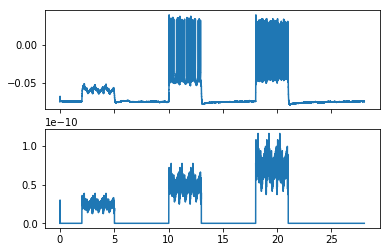

In [214]:

t = np.arange(0,sweeps[i]['index_range'][1]+1)*1.0/sweeps[i]['sampling_rate']
fig,ax = plt.subplots(2,1,sharex=True)
ax[1].plot(t,sweeps[i]['stimulus'])
ax[0].plot(t,sweeps[i]['response'])
# plt.xlim(10.3,10.31)
# print sweeps[5]['index_range']
# print sweeps[5]['sampling_rate']
print sweeps[0].keys()


In [ ]:
plt.plot(t,sweeps[i]['stimulus'])
plt.plot((np.arange(0,binned_stim.shape[1])+0.5)*bin_len,np.squeeze(binned_stim))
plt.xlim([10.3,10.35])

(10.3, 10.5)

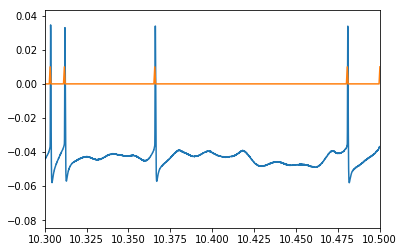

In [12]:
plt.plot(t,sweeps[i]['response'])
plt.plot((np.arange(0,binned_stim.shape[1])+0.5)*bin_len,np.squeeze(binned_spikes)*0.01)
plt.xlim([10.3,10.5])

In [62]:
# from keras.engine.base_layer import Layer
# class FPrb(Layer):

#     def __init__(self,dt, **kwargs):
#         self.dt = dt
#         super(FPrb, self).__init__(**kwargs)

#     def build(self, input_shape):
#         # Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(input_shape[-1],1),
#                                       initializer='glorot_normal',
#                                       trainable=True)
#         self.built = True

#     def call(self, x):
#         return K.exp(K.dot(x, self.kernel))*self.dt
# #         return (K.dot(x, self.kernel))


#     def compute_output_shape(self, input_shape):
#         return (None,input_shape[0])

In [15]:
# def negloglikelihood(y_true,y_pred):
# #     return -(-y_pred+y_true*K.log(y_pred))
#     return -(-K.exp(y_pred)*1e-1+y_true*y_pred)



In [16]:
# def neglog_likelihood_poisson(theta, X, y):
#     return -np.dot(y.T,np.dot(X,theta)) + np.sum(np.exp(np.dot(X,theta))*1e-1)

# X = np.random.random([20000,30])
# beta = np.random.random([30, 1])*0.2
# w = np.exp(np.dot(X,beta))*0.1
# print np.max(w)
# y = np.random.poisson(lam=w, size=np.shape(w))
# myguess = np.random.normal(loc=0.0, scale= 1.0, size=np.shape(beta))
# print(np.shape(myguess))
# res = minimize(neglog_likelihood_poisson, args = (X,y), method = 'CG', x0 = myguess, options={'gtol':1e-14})
# plt.scatter(beta, res.x)

In [184]:
# inp = Input(shape=(Xdsn.shape[1],))
# out = FPrb(bin_len)(inp)
# model = Model(inputs = [inp], outputs = [out])
# print model.summary()
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=8e-2))

In [18]:
# from keras import Sequential
# from keras.layers import Dense, Lambda
# model = Sequential()
# model.add(Dense(1,input_dim = X.shape[1],use_bias=True))
# model.add(Lambda(lambda x: K.exp(x)*0.1))
# print model.summary()
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-3))
# model.fit(x=X,y=y,epochs=200,batch_size = 1000)

In [19]:
# print np.exp(model.get_weights()[1])
# plt.scatter(beta, model.get_weights()[0])

In [20]:
# from keras import Sequential
# from keras.layers import Dense, Lambda
# model = Sequential()
# model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True))
# model.add(Lambda(lambda x: K.exp(x)*bin_len))
# print model.summary()
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=2e-1))


In [185]:
# model.fit(x=Xdsn,y=ydsn,epochs=150,batch_size = 1000000)

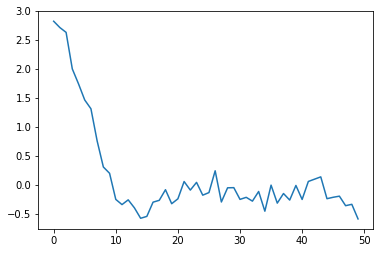

In [74]:
p = model.get_weights()[0]
# print np.exp(model.get_weights()[1])
plt.plot(p[:d])

In [ ]:
(F,W,b,losses,models) = GLM_network_fit(binned_stim*1e9,binned_spikes, d, d, bin_len)

[0.08559065]


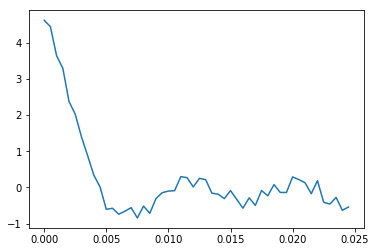

In [53]:
print np.exp(b)
plt.plot(np.arange(d)*bin_len,np.squeeze(F))

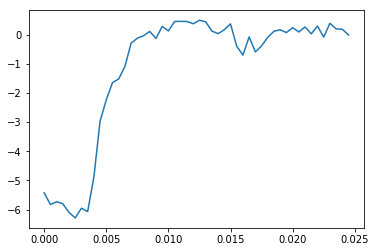

In [32]:
plt.plot(np.arange(d)*bin_len,np.squeeze(W))

In [79]:
# myguess = np.random.normal(loc=0.0, scale= 1.0, size=(Xdsn.shape[1],1))
# print(np.shape(myguess))
# res = minimize(log_likelihood_poisson, args = (Xdsn,y), method = 'CG', x0 = myguess, options={'gtol':1e-14})

In [169]:
# from keras.engine.base_layer import Layer
# class FPrb(Layer):

#     def __init__(self,t,num_exp=2, **kwargs):
#         self.dt = t[1]-t[0]
#         self.t = np.expand_dims(t,1)
#         self.T = len(t)
#         self.num_exp = num_exp
#         super(FPrb, self).__init__(**kwargs)

#     def build(self, input_shape):
#         # Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(2*self.num_exp*input_shape[1]/self.T+1,),   # [4p stim1, 4p stim2, ... , 4p spk1, 4p spk2,... ]
#                                       initializer='uniform',
#                                       trainable=True)
#         self.built = True

#     def call(self, x):
#         F = 0.0
#         for i in range(K.int_shape(self.kernel)[0]/(2*self.num_exp)):
# #             F += K.dot(x[:,i*self.T:(i+1)*self.T],self.kernel[i*2*self.num_exp]*K.exp(self.kernel[i*2*self.num_exp+1]*self.t)+self.kernel[i*4+2]*K.exp(self.kernel[i*4+3]*self.t))
#             for j in range(self.num_exp):
#                 F += K.dot(x[:,i*self.T:(i+1)*self.T],self.kernel[i*2*self.num_exp+j*2]*K.exp(self.kernel[i*2*self.num_exp+j*2+1]*self.t))
#         F+=self.kernel[-1]
#         return K.exp(F)*self.dt


#     def compute_output_shape(self, input_shape):
#         return (None,input_shape[0])

# inp = Input(shape=(Xdsn.shape[1],))
# out = FPrb(np.arange(d)*bin_len)(inp)
# model = Model(inputs = [inp], outputs = [out])
# model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-1))
# print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 100)               0         
_________________________________________________________________
f_prb_40 (FPrb)              (None, None)              9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x=Xdsn,y=ydsn,epochs=50,batch_size = 1000)

In [377]:
# t = np.arange(d)*bin_len
# # p = model.get_weights()[0]
# print np.exp(p[-1])
# print p
# w=0
# # plt.plot(t,p[2-w]*np.exp(p[3-w]*t))
# plt.plot(t,p[4-w]*np.exp(p[5-w]*t)+p[6-w]*np.exp(p[7-w]*t))

In [ ]:
bin_len = 0.001
d=30
t = np.arange(d)*bin_len
layers = np.unique(cells.structure_layer_name.values)
F_clumps = {}
W_clumps = {}
b_clumps = {}
for layer in layers:
    print layer
#     cell_ids = inh_cells[inh_cells.structure_layer_name==layer]['id'].values
    cell_ids = exc_cells[exc_cells.structure_layer_name==layer]['id'].values

    if len(cell_ids)>5:
        F_clump = []
        W_clump = []
        b_clump = []
        for i, cell_id in enumerate(cell_ids):
            print i, '/', len(cell_ids)
            sweeps = get_sweeps_with_stim(ctc.get_ephys_data(cell_id),'Noise')
            if len(sweeps)>0:
                (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
                (F,W,b) = GLM_network_fit(binned_stim*1e9,binned_spikes, d, d, bin_len)
                F_clump.append(np.squeeze(F))
                W_clump.append(np.squeeze(W))
                b_clump.append(np.squeeze(b))
                
        F_clumps[layer] = np.vstack(F_clump)
        W_clumps[layer] = np.vstack(W_clump)
        b_clumps[layer] = np.vstack(b_clump)


1
2/3
4
5
0 / 361
1 / 361
2 / 361
3 / 361
4 / 361
5 / 361
6 / 361
7 / 361
8 / 361
9 / 361
10 / 361
11 / 361
12 / 361
13 / 361
14 / 361
15 / 361
16 / 361
17 / 361
18 / 361
19 / 361
20 / 361
21 / 361
22 / 361
23 / 361
24 / 361
25 / 361
26 / 361
27 / 361
28 / 361
29 / 361
30 / 361
31 / 361
32 / 361
33 / 361
34 / 361
35 / 361
36 / 361
37 / 361
101 / 361
102 / 361
103 / 361
104 / 361
105 / 361
106 / 361
107 / 361
108 / 361
109 / 361
110 / 361
111 / 361
112 / 361
113 / 361
114 / 361
115 / 361
116 / 361
117 / 361
118 / 361
119 / 361
120 / 361
121 / 361
122 / 361
123 / 361
124 / 361
125 / 361
126 / 361
127 / 361
128 / 361
129 / 361
130 / 361
131 / 361
132 / 361
133 / 361
134 / 361
135 / 361
136 / 361
137 / 361
138 / 361
139 / 361
140 / 361
141 / 361
142 / 361
143 / 361
144 / 361
145 / 361
146 / 361
147 / 361
148 / 361
149 / 361
150 / 361
151 / 361
152 / 361
153 / 361
154 / 361
155 / 361
156 / 361
157 / 361
158 / 361
159 / 361
160 / 361
161 / 361
162 / 361
163 / 361
164 / 361
165 / 361
166 / 36

In [24]:
np.savez('inh_clumps',F_clumps_inh[lay],W_clumps_inh[lay],b_clumps_inh[lay])
# F_clumps_inh = F_clumps.copy()
# W_clumps_inh = W_clumps.copy()
# b_clumps_inh = b_clumps.copy()

<StemContainer object of 3 artists>

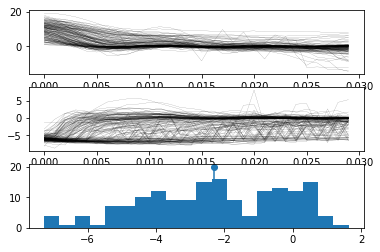

In [20]:
t = np.arange(d)*bin_len
lay = '5'
F_means = np.mean(F_clumps[lay],axis = 0)
W_means = np.mean(W_clumps[lay],axis = 0)
b_mean = np.mean(b_clumps[lay])

fig,ax = plt.subplots(3,1)
for i in range(b.shape[0]):
    ax[0].plot(t,F_clumps[lay].T,'k',linewidth = 0.1)
    ax[1].plot(t,W_clumps[lay].T,'k',linewidth = 0.1)
ax[0].plot(t,F_means,'k',linewidth = 0.1)
ax[1].plot(t,W_means,'k',linewidth = 0.1)
ax[2].hist(b_clumps[lay],bins = 20)
ax[2].stem([b_mean],[20])


(array([ 1.,  0.,  1.,  2., 26., 40., 45., 14., 11.,  7.,  7.,  2.,  1.,
         1.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([-8.74230099, -8.32319498, -7.90408898, -7.48498298, -7.06587697,
        -6.64677097, -6.22766497, -5.80855896, -5.38945296, -4.97034695,
        -4.55124095, -4.13213495, -3.71302894, -3.29392294, -2.87481694,
        -2.45571093, -2.03660493, -1.61749893, -1.19839292, -0.77928692,
        -0.36018091]),
 <a list of 20 Patch objects>)

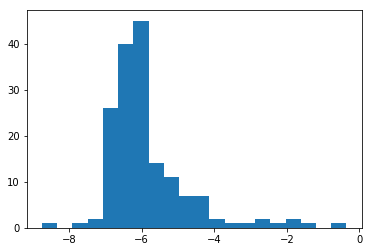

In [18]:
i = 1
plt.hist(W_clumps[lay][:,i],bins=20)

In [242]:
# def GLM_network_fit_exps(stimulus,spikes,d_stim, d_spk,bin_len,num_exp=2,f='exp',priors=None,L1=None):
#     N = spikes.shape[0]
#     M = stimulus.shape[0]
#     F = np.empty((N,M,num_exp*2)) # stimulus filters
#     W = np.empty((N,N,num_exp*2))  # spike train filters
#     b = np.empty((N,)) # biases
#     fs = {'exp':K.exp}
#     Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
#     for i in range(N):
#         y = spikes[i,max(d_stim,d_spk):]
#         # construct GLM model and return fit
#         inp = Input(shape=(Xdsn.shape[1],))
#         out = FPrb(np.arange(d)*bin_len,num_exp=num_exp)(inp)
#         model = Model(inputs = [inp], outputs = [out])
#         model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=5e-2))
#         model.fit(x=Xdsn,y=y,epochs=200,batch_size = 1000,verbose=0)
#         p = model.get_weights()[0]
#         F[i,:,:] = p[:M*num_exp*2].reshape((M,num_exp*2))
#         W[i,:,:] = p[M*num_exp*2:-1].reshape((N,num_exp*2))
#         b[i] = p[-1]
#     return (F,W,b)

In [ ]:
# fig,ax = plt.subplots(2,1)
# for spec_id in inh_cells['id'].values[1:2]:
#     print spec_id
#     sweeps = get_sweeps_with_stim(ctc.get_ephys_data(spec_id),'Noise')
#     if len(sweeps)>0:
#         (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
#         (F,W,b) = GLM_network_fit_exps(binned_stim*1e9,binned_spikes, d, d, bin_len)
#         F = np.squeeze(F)
#         W = np.squeeze(W)
#         print F,W,b
#         ax[0].plot(t,F[0]*np.exp(F[1]*t)+F[2]*np.exp(F[3]*t))
#         ax[1].plot(t,W[0]*np.exp(W[1]*t)+W[2]*np.exp(W[3]*t))

In [248]:
# from scipy.optimize import differential_evolution

# def EvalExpFit(x, a, b):
#     return np.dot(a, np.exp(-np.outer(b, x)))

# def ExpFitDiffEvol(N, x, y):
#     """Fit N-exponential decay to a dataseries (x, y) using differential
#     evolution as implemented in scipy.optimize.
#     Parameters
#     ----------
#     N : float
#         number of summed exponentials to fit
#     x : array
#         x values
#     y : array
#         y values
#         returns a, b
#         len(a) = N
#         len(b) = N
#         y(x) = \sum_{i=1}^N a_i \exp ( - b_i x )
#         Use of differntial evolution inspired by use of another genetic algorithm
#         to perform exponential fit of by Weizhong Zou in
            
#             Zou, Weizhong. Larson, Ronald G.
#             "A mesoscopic simulation method for predicting the rheology of
#             semi-dilute wormlike micellar solutions." Journal of Rheology. 58,
#             681 (2014).
#     """
#     x = np.array(x)
#     y = np.array(y)

#     bounds = [[min(x), max(x)]]*N + [[min(y), max(y)]]*N

#     def objective(s):
#         taui, fi = np.split(s, 2)
#         return np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2.)

#     result = differential_evolution(objective, bounds)
#     s = result['x']
#     taui, fi = np.split(s, 2)
#     return fi, 1./taui

In [ ]:
# nexp = 5
# W_fir = np.squeeze(W_fir)
# fit_inds = range(np.argmax(np.diff(W_fir)),W_fir.shape[0]-1)
# fit_inds.extend(range(np.argmax(np.diff(W_fir)), np.argmin(np.diff(W_fir))+2))
# fit_inds.extend(range(np.argmax(np.diff(W_fir)), np.argmin(np.diff(W_fir))+2))

# # fit_inds = range(np.argmax(np.diff(W_fir)), np.argmin(np.diff(W_fir))+2)
# # fit_inds.append(W_fir.shape[0]-1)
# print fit_inds
# (a,b) = ExpFitDiffEvol(nexp,t[fit_inds],W_fir[fit_inds])
# print a, b
# # a = [10,-30]
# # b = [350,900]
# # a = [-7.06*3,3.3]
# # b = [938,159]

# # plt.plot(t[fit_inds],EvalExpFit(t[fit_inds],a,b))
# # plt.plot(t[fit_inds],W_fir[fit_inds])
# plt.plot(t,EvalExpFit(t,a,b))
# plt.plot(t,W_fir)

In [ ]:
# plt.plot(np.hstack([1*np.ones((5,1)),2*np.ones((5,1)),3*np.ones((5,1)),4*np.ones((5,1))]))
# print bin_len